## **[1] Importing required libraries and packages**

In [2]:
# Importing the necessary packages
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets   as torch_datasets
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torch.utils.data   import Dataset
from   torchsummary       import summary
import tqdm.notebook as tq
import warnings
warnings.filterwarnings("ignore")

## **[2] Loading MNIST Dataset from torchivision datasets**

In [3]:
'''
    Transformation to be applied to the images before giving as input to model
    transforms.Compose() applies the transforms one after the other
    transforms.ToTensor() converts an np.array or PIL image into a pytorch tensor AND also compresses [0,255] 
    pixel range PIL Image (or uint8 array) into [0.,1.] float. In the other cases, tensors are returned WITHOUT scaling.
    (0.1307,), (0.3081,) is the mean and standard deviation for MNIST data
'''

# Applying Random affine transformations to the training data
transformations_train = transforms.Compose([transforms.RandomAffine(degrees=7)
                                            ,transforms.ToTensor()
                                            ,transforms.Normalize((0.1307,), (0.3081,))
                                           ])

# The test data must not be randomly rotated, translated, etc. while validation, hence a different transform Compose
transformations_test = transforms.Compose([transforms.ToTensor()
                                    , transforms.Normalize((0.1307,), (0.3081,))])

# Loading a training set of X images and Test set of Y images (: split)
train_set = torch_datasets.MNIST('../mnist_data', train=True,
                                 download=True, transform=transformations_train)

test_set  = torch_datasets.MNIST('../mnist_data', train=False,
                                 download=True, transform=transformations_test)


Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw


Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw


Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw


Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw
Processing...
Done!


## **[3] Making dataloader and getting number of classes**

In [38]:
SEED = 1                 # Set Randomization seed for Reproducible results

torch.manual_seed(SEED)                 
use_cuda = torch.cuda.is_available()    # Checks if Cuda is available, and returns True if yes

if use_cuda:
    torch.cuda.manual_seed(SEED)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Creating train and test sample loaders
def loader(batch_size_train,batch_size_test):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size_train, shuffle=True, **kwargs)
    test_loader  = torch.utils.data.DataLoader(test_set , batch_size = batch_size_test , shuffle=True, **kwargs)
    return train_loader,test_loader

'''
    The following 7 lines are to assert whether both training and test sets have the same number/type of 
    classes (with the same labelling) for classification, and assign the number to a variable 
    'num_classes' which will be equal to the number of kernel that will be used later in the 
    final convolution layer.
 '''
classes_in_train = train_set.targets.unique().numpy()
classes_in_test  = test_set.targets.unique().numpy()
assert np.isin(classes_in_test,classes_in_train).all()

num_classes = len(train_set.targets.unique().numpy())
print(f'Number of classes in MNIST: {num_classes}')
print(f'Number of images for training  : {len(train_set)}')
print(f'Number of images for validation: {len(test_set)}')

Number of classes in MNIST: 10
Number of images for training  : 60000
Number of images for validation: 10000


## **[4] CNN Model**

### **[4.1] GhostBatchNorm Function**

In [39]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

### **[4.2] CNN Network**

In [40]:

class Net(nn.Module):
    '''
        nn.Module is the base class for all Neural Network Modules, the Net() class is inheriting the base class nn.Module
        A Module contains the state of the layers in a Neural network and methods for feedforward and training the model
    '''
    # BN_flag 0: normal batchnorm; 1: Ghost batchnorm
    def Batch_Norm_Layer(self,channels,BN_type='BN'):
        '''
            BN_type == 1 -> GhostBatchNorm()
            BN_type != 1 -> nn.BatchNorm2d()
            Selects the type of Batch Normalization which is to be used
        '''
        if BN_type == 'GBN':
            return GhostBatchNorm(channels, num_splits=2, weight=False)
        elif BN_type == 'BN':
            return nn.BatchNorm2d(channels)

    def __init__(self,BN_type='BN'):
        super(Net, self).__init__() 
        # Conv Block 1
        drop = 0.05          # Dropout Percentage
        self.convblock1 = nn.Sequential(
                                                                   #     INPUT    |    OUTPUT     | Receptive Field
            nn.Conv2d( 1, 8, 3,padding=1,bias=False),              # In: 28x28x1  | Out: 28x28x8  |      RF:3
            Batch_Norm_Layer(self,8,BN_type),                      # In: 28x28x8  | Out: 28x28x8  |      RF:3
            nn.ReLU(),                                             # In: 28x28x8  | Out: 28x28x8  |      RF:3
            nn.Dropout(p=drop),                                    # In: 28x28x8  | Out: 28x28x8  |      RF:3

            nn.Conv2d(8, 12, 3,padding=1,bias=False),              # In: 28x28x8  | Out: 28x28x12 |      RF:5
            Batch_Norm_Layer(self,12,BN_type),                     # In: 28x28x12 | Out: 28x28x12 |      RF:5
            nn.ReLU(),                                             # In: 28x28x12 | Out: 28x28x12 |      RF:5
            nn.Dropout(p=drop),                                    # In: 28x28x12 | Out: 28x28x12 |      RF:5

            nn.Conv2d(12, 16, 3,bias=False),                       # In: 28x28x12 | Out: 26x26x16 |      RF:7
            Batch_Norm_Layer(self,16,BN_type),                     # In: 26x26x16 | Out: 26x26x16 |      RF:7
            nn.ReLU(),                                             # In: 26x26x16 | Out: 26x26x16 |      RF:7
            nn.Dropout(p=drop)                                     # In: 26x26x16 | Out: 26x26x16 |      RF:7
        )
        
        # Transition 1 
        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                                    # In: 26x26x16 | Out: 13x13x16 |      RF:8
            nn.Conv2d(16, 8, 1,bias=False),                        # In: 13x13x16 | Out: 13x13x8  |      RF:12
            Batch_Norm_Layer(self,8,BN_type),                      # In: 13x13x8  | Out: 13x13x8  |      RF:12
            nn.ReLU(),                                             # In: 13x13x8  | Out: 13x13x8  |      RF:12
            nn.Dropout(p=drop)                                     # In: 13x13x8  | Out: 13x13x8  |      RF:12
        )

        # Conv Block 2 
        self.convblock2 = nn.Sequential(
        nn.Conv2d(8, 12, 3,bias=False),                            # In: 13x13x8 | Out: 11x11x12 |      RF:16
        Batch_Norm_Layer(self,12,BN_type),                         # In: 11x11x12| Out: 11x11x12 |      RF:16
        nn.ReLU(),                                                 # In: 11x11x12| Out: 11x11x12 |      RF:16
        nn.Dropout(p=drop),                                        # In: 11x11x12| Out: 11x11x12 |      RF:16

        nn.Conv2d(12, 16, 3,bias=False),                           # In: 11x11x16| Out:  9x9x16  |      RF:20
        Batch_Norm_Layer(self,16,BN_type),                         # In: 9x9x16  | Out:  9x9x16  |      RF:20
        nn.ReLU(),                                                 # In: 9x9x16  | Out:  9x9x16  |      RF:20
        nn.Dropout(p=drop),                                        # In: 9x9x16  | Out:  9x9x16  |      RF:20

        nn.Conv2d(16, 16, 3,bias=False),                           # In: 9x9x16  | Out:  7x7x16  |      RF:24
        Batch_Norm_Layer(self,16,BN_type),                         # In: 7x7x16  | Out:  7x7x16  |      RF:24
        nn.ReLU(),                                                 # In: 7x7x16  | Out:  7x7x16  |      RF:24
        nn.Dropout(p=drop)                                         # In: 7x7x16  | Out:  7x7x16  |      RF:24
        )

        # Output Block                
        self.outblock = nn.Sequential(
            nn.Conv2d(16, num_classes, 3,bias=False),              # In: 7x7x16  | Out:  5x5x10  |      RF:28
            nn.AvgPool2d(kernel_size=5)                            # In: 5x5x10  | Out:  1x1x10  |      RF:36
        )
        

    def forward(self, x):
        '''
            Method for passing the input image through the network to get the output
            x here is a tensor at each stage, with the dimensions [N, C, H, W]:- 
            {N = No. of Samples, C = No. of channels, H = Height of Image, W = Width of Image}
        '''
        x = self.convblock1(x)
        x = self.transblock1(x)
        x = self.convblock2(x)
        x = self.outblock(x)
        x = x.view(-1, 10)               # Reshaping the tensor to a tensor with 10 columns and appropriate numbe of rows
        return F.log_softmax(x,dim=1)    # Computing Softmax of the obtained output

## **[5] Model Summary and Parameters**

In [41]:
device = torch.device("cuda" if use_cuda else "cpu") # Selects whether to run the model on GPU or CPU
model = Net(BN_type='GBN').to(device)                # Loads the model weights on the gpu or cpu
summary(model, input_size=(1, 28, 28))  # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
    GhostBatchNorm-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]             864
    GhostBatchNorm-6           [-1, 12, 28, 28]              24
              ReLU-7           [-1, 12, 28, 28]               0
           Dropout-8           [-1, 12, 28, 28]               0
            Conv2d-9           [-1, 16, 26, 26]           1,728
   GhostBatchNorm-10           [-1, 16, 26, 26]              32
             ReLU-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
        MaxPool2d-13           [-1, 16, 13, 13]               0
           Conv2d-14            [-1, 8,

## **[6] Train and Test functions**

In [42]:
def train(model, device, train_loader, optimizer, epoch,L1_param=0,L2_param=0):
    model.train()
    pbar = tq.tqdm(train_loader,leave=False)
    correct,processed = 0,0

    if L2_param > 0:
        optimizer.param_groups[0]['weight_decay'] = L2_param

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device) # get samples
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. 
        # It’s important to call optimizer.zero_grad() before loss.backward(), otherwise gradients will be accumulated from multiple passes.
        y_pred = model(data)   # The feed forward pass for generating output from data
        loss = F.nll_loss(y_pred, target)

        if L1_param > 0:
            sum_weights = 0
            for param in model.parameters():
                sum_weights += torch.sum(abs(param))
            loss += (L1_param * sum_weights)
        
        loss.backward()         # Calculates the d(loss)/dx for each parameter x, which are accumulated into x.grad
        optimizer.step()        # optimizer.step() multiples the learing rate with the x.grad and updates each model parameter
        
        # Update pbar-tqdm
        pred        = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct    += pred.eq(target.view_as(pred)).sum().item()
        processed  += len(data)
        acc         = 100*(correct/processed)
        string_name = 'Epoch={} | Batch={} | Loss={:.4f} | Acc={:.2f}'.format(epoch,batch_idx,loss.item(),acc)
        pbar.set_description(desc=string_name) # Updates the description at every timestep while showing the progress bar
    
    # ---- Obtaining Training Accuracy for EPOCH -------
    model.eval() 
    total_train_loss = 0
    correct_train    = 0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption 
    with torch.no_grad():
        for data, target in train_loader:
            data, target   = data.to(device), target.to(device)
            output         = model(data)
            total_train_loss += F.nll_loss(output, target, reduction='sum').item()   # sums up the loss for all samples in a batch
            pred           = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_train += pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target
    
    train_loss     = total_train_loss/len(train_loader.dataset)
    train_accuracy = 100. * (correct_train / len(train_loader.dataset))
    print('\nEpoch:{} Learning Rate:{}\nTrain Set: Mean loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%)'.format(epoch,
        optimizer.param_groups[0]['lr'], train_loss, correct_train, len(train_loader.dataset),train_accuracy))
    return train_loss,train_accuracy

def test(model, device, test_loader):
    model.eval()
    total_test_loss = 0
    correct_test    = 0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            total_test_loss += F.nll_loss(output, target, reduction='sum').item()  # sums up the loss for all samples in a batch
            pred         = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_test+= pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target

    test_loss = total_test_loss/len(test_loader.dataset)
    test_accuracy = 100. * (correct_test / len(test_loader.dataset))
    print('Test Set : Mean loss: {:.4f}, Test Accuracy : {}/{} ({:.2f}%)\n'.format(
        test_loss, correct_test, len(test_loader.dataset),test_accuracy))
    return test_loss,test_accuracy

## **[7] Training the model**

In [45]:
epochs = 25              # No. of training epochs
lr_step_size = 4         # Setting the number of epochs after which LR updates by the scheduler

# Empty lists for storing the lists of training/test loss and accuracy values from different version runs
train_loss_lists = []
train_acc_lists  = []
test_loss_lists  = []
test_acc_lists   = []

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Batch size (training) with BatchNormalization      = 128
# Batch size (training) with GhostBatchNormalization = 32
for version in range(1,6):
    if version == 1:     # with L1 + BN
        model = Net(BN_type='BN').to(device)
        L1 = 0.001
        L2 = 0
        train_loader, test_loader = loader(batch_size_train = 128, batch_size_test = 1024)

    if version == 2:     # with L2 + BN
        model = Net(BN_type='BN').to(device)
        L1 = 0
        L2 = 0.001
        train_loader, test_loader = loader(batch_size_train = 128, batch_size_test = 1024)

    if version == 3:     # with L1 and L2 with BN
        model = Net(BN_type='BN').to(device)
        L1 = 0.001
        L2 = 0.001
        train_loader, test_loader = loader(batch_size_train = 128, batch_size_test = 1024)
    
    if version == 4:     # with GBN
        model = Net(BN_type='GBN').to(device)
        L1 = 0
        L2 = 0
        train_loader, test_loader = loader(batch_size_train = 32, batch_size_test = 1024)
    
    if version == 5:     # with L1 and L2 with BN
        model = Net(BN_type='GBN').to(device)
        L1 = 0.001
        L2 = 0.001
        train_loader, test_loader = loader(batch_size_train = 32, batch_size_test = 1024)
    
    train_loss_vals = []
    train_acc_vals  = []
    test_loss_vals  = []
    test_acc_vals   = []

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = lr_step_size, gamma=0.7)
    # gamma in the scheduler is the rate at which the learning rate will update at each scheduler step
    max_test_acc = 0
    for epoch in range(0, epochs):
        print("------------------- [Version {}] -------------------".format(version))
        train_loss,train_acc = train(model, device, train_loader, optimizer, epoch, L1_param = L1, L2_param = L2)
        test_loss,test_acc   = test(model, device, test_loader)
        if (test_acc > max_test_acc): # Save the best performing model
            model_path = '../mnist_data/models/S6_best_model_version_'+ str(version)
            torch.save(model.state_dict(), model_path)
            max_test_acc = test_acc
        scheduler.step()       # FOR LR UPDATE
        train_loss_vals.append(train_loss)
        test_loss_vals.append(test_loss)
        train_acc_vals.append(train_acc)
        test_acc_vals.append(test_acc)
    
    train_loss_lists.append(train_loss_vals)
    train_acc_lists.append(train_acc_vals)
    test_loss_lists.append(test_loss_vals)
    test_acc_lists.append(test_acc_vals)

------------------- [Version 1] -------------------



Epoch:0 Learning Rate:0.01
Train Set: Mean loss: 0.1139, Train Accuracy: 58149/60000 (96.91%)
Test Set : Mean loss: 0.0882, Test Accuracy : 9773/10000 (97.73%)

------------------- [Version 1] -------------------



Epoch:1 Learning Rate:0.01
Train Set: Mean loss: 0.1298, Train Accuracy: 57715/60000 (96.19%)
Test Set : Mean loss: 0.1105, Test Accuracy : 9662/10000 (96.62%)

------------------- [Version 1] -------------------



Epoch:2 Learning Rate:0.01
Train Set: Mean loss: 0.0873, Train Accuracy: 58509/60000 (97.52%)
Test Set : Mean loss: 0.0715, Test Accuracy : 9799/10000 (97.99%)

------------------- [Version 1] -------------------



Epoch:3 Learning Rate:0.01
Train Set: Mean loss: 0.0882, Train Accuracy: 58470/60000 (97.45%)
Test Set : Mean loss: 0.0668, Test Accuracy : 9807/10000 (98.07%)

------------------- [Version 1] -------------------



Epoch:4 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0692, Train Accuracy: 58747/60000 (97.91%)
Test Set : Mean loss: 0.0539, Test Accuracy : 9827/10000 (98.27%)

------------------- [Version 1] -------------------



Epoch:5 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.1000, Train Accuracy: 58224/60000 (97.04%)
Test Set : Mean loss: 0.0803, Test Accuracy : 9757/10000 (97.57%)

------------------- [Version 1] -------------------



Epoch:6 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0698, Train Accuracy: 58767/60000 (97.95%)
Test Set : Mean loss: 0.0549, Test Accuracy : 9836/10000 (98.36%)

------------------- [Version 1] -------------------



Epoch:7 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0812, Train Accuracy: 58639/60000 (97.73%)
Test Set : Mean loss: 0.0666, Test Accuracy : 9808/10000 (98.08%)

------------------- [Version 1] -------------------



Epoch:8 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0693, Train Accuracy: 58788/60000 (97.98%)
Test Set : Mean loss: 0.0559, Test Accuracy : 9838/10000 (98.38%)

------------------- [Version 1] -------------------



Epoch:9 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0664, Train Accuracy: 58805/60000 (98.01%)
Test Set : Mean loss: 0.0547, Test Accuracy : 9831/10000 (98.31%)

------------------- [Version 1] -------------------



Epoch:10 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0941, Train Accuracy: 58310/60000 (97.18%)
Test Set : Mean loss: 0.0715, Test Accuracy : 9786/10000 (97.86%)

------------------- [Version 1] -------------------



Epoch:11 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0672, Train Accuracy: 58854/60000 (98.09%)
Test Set : Mean loss: 0.0492, Test Accuracy : 9870/10000 (98.70%)

------------------- [Version 1] -------------------



Epoch:12 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0556, Train Accuracy: 59006/60000 (98.34%)
Test Set : Mean loss: 0.0433, Test Accuracy : 9869/10000 (98.69%)

------------------- [Version 1] -------------------



Epoch:13 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0517, Train Accuracy: 59109/60000 (98.52%)
Test Set : Mean loss: 0.0395, Test Accuracy : 9886/10000 (98.86%)

------------------- [Version 1] -------------------



Epoch:14 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0513, Train Accuracy: 59123/60000 (98.54%)
Test Set : Mean loss: 0.0402, Test Accuracy : 9886/10000 (98.86%)

------------------- [Version 1] -------------------



Epoch:15 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0581, Train Accuracy: 58954/60000 (98.26%)
Test Set : Mean loss: 0.0467, Test Accuracy : 9857/10000 (98.57%)

------------------- [Version 1] -------------------



Epoch:16 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0514, Train Accuracy: 59092/60000 (98.49%)
Test Set : Mean loss: 0.0419, Test Accuracy : 9871/10000 (98.71%)

------------------- [Version 1] -------------------



Epoch:17 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0576, Train Accuracy: 58948/60000 (98.25%)
Test Set : Mean loss: 0.0473, Test Accuracy : 9857/10000 (98.57%)

------------------- [Version 1] -------------------



Epoch:18 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0508, Train Accuracy: 59063/60000 (98.44%)
Test Set : Mean loss: 0.0409, Test Accuracy : 9876/10000 (98.76%)

------------------- [Version 1] -------------------



Epoch:19 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0691, Train Accuracy: 58796/60000 (97.99%)
Test Set : Mean loss: 0.0588, Test Accuracy : 9836/10000 (98.36%)

------------------- [Version 1] -------------------



Epoch:20 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0436, Train Accuracy: 59223/60000 (98.70%)
Test Set : Mean loss: 0.0351, Test Accuracy : 9901/10000 (99.01%)

------------------- [Version 1] -------------------



Epoch:21 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0486, Train Accuracy: 59134/60000 (98.56%)
Test Set : Mean loss: 0.0400, Test Accuracy : 9885/10000 (98.85%)

------------------- [Version 1] -------------------



Epoch:22 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0557, Train Accuracy: 58979/60000 (98.30%)
Test Set : Mean loss: 0.0421, Test Accuracy : 9871/10000 (98.71%)

------------------- [Version 1] -------------------



Epoch:23 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0441, Train Accuracy: 59222/60000 (98.70%)
Test Set : Mean loss: 0.0356, Test Accuracy : 9892/10000 (98.92%)

------------------- [Version 1] -------------------



Epoch:24 Learning Rate:0.0011764899999999994
Train Set: Mean loss: 0.0412, Train Accuracy: 59298/60000 (98.83%)
Test Set : Mean loss: 0.0362, Test Accuracy : 9886/10000 (98.86%)

------------------- [Version 2] -------------------



Epoch:0 Learning Rate:0.01
Train Set: Mean loss: 0.0934, Train Accuracy: 58378/60000 (97.30%)
Test Set : Mean loss: 0.0772, Test Accuracy : 9787/10000 (97.87%)

------------------- [Version 2] -------------------



Epoch:1 Learning Rate:0.01
Train Set: Mean loss: 0.0630, Train Accuracy: 58850/60000 (98.08%)
Test Set : Mean loss: 0.0536, Test Accuracy : 9841/10000 (98.41%)

------------------- [Version 2] -------------------



Epoch:2 Learning Rate:0.01
Train Set: Mean loss: 0.0518, Train Accuracy: 59068/60000 (98.45%)
Test Set : Mean loss: 0.0431, Test Accuracy : 9875/10000 (98.75%)

------------------- [Version 2] -------------------



Epoch:3 Learning Rate:0.01
Train Set: Mean loss: 0.0455, Train Accuracy: 59185/60000 (98.64%)
Test Set : Mean loss: 0.0360, Test Accuracy : 9900/10000 (99.00%)

------------------- [Version 2] -------------------



Epoch:4 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0371, Train Accuracy: 59329/60000 (98.88%)
Test Set : Mean loss: 0.0286, Test Accuracy : 9921/10000 (99.21%)

------------------- [Version 2] -------------------



Epoch:5 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0345, Train Accuracy: 59366/60000 (98.94%)
Test Set : Mean loss: 0.0275, Test Accuracy : 9923/10000 (99.23%)

------------------- [Version 2] -------------------



Epoch:6 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0337, Train Accuracy: 59401/60000 (99.00%)
Test Set : Mean loss: 0.0272, Test Accuracy : 9928/10000 (99.28%)

------------------- [Version 2] -------------------



Epoch:7 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0334, Train Accuracy: 59414/60000 (99.02%)
Test Set : Mean loss: 0.0259, Test Accuracy : 9918/10000 (99.18%)

------------------- [Version 2] -------------------



Epoch:8 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0284, Train Accuracy: 59486/60000 (99.14%)
Test Set : Mean loss: 0.0224, Test Accuracy : 9935/10000 (99.35%)

------------------- [Version 2] -------------------



Epoch:9 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0290, Train Accuracy: 59483/60000 (99.14%)
Test Set : Mean loss: 0.0255, Test Accuracy : 9926/10000 (99.26%)

------------------- [Version 2] -------------------



Epoch:10 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0306, Train Accuracy: 59444/60000 (99.07%)
Test Set : Mean loss: 0.0265, Test Accuracy : 9918/10000 (99.18%)

------------------- [Version 2] -------------------



Epoch:11 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0267, Train Accuracy: 59541/60000 (99.23%)
Test Set : Mean loss: 0.0230, Test Accuracy : 9933/10000 (99.33%)

------------------- [Version 2] -------------------



Epoch:12 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0241, Train Accuracy: 59594/60000 (99.32%)
Test Set : Mean loss: 0.0212, Test Accuracy : 9932/10000 (99.32%)

------------------- [Version 2] -------------------



Epoch:13 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0259, Train Accuracy: 59561/60000 (99.27%)
Test Set : Mean loss: 0.0226, Test Accuracy : 9935/10000 (99.35%)

------------------- [Version 2] -------------------



Epoch:14 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0235, Train Accuracy: 59603/60000 (99.34%)
Test Set : Mean loss: 0.0207, Test Accuracy : 9945/10000 (99.45%)

------------------- [Version 2] -------------------



Epoch:15 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0264, Train Accuracy: 59524/60000 (99.21%)
Test Set : Mean loss: 0.0241, Test Accuracy : 9923/10000 (99.23%)

------------------- [Version 2] -------------------



Epoch:16 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0229, Train Accuracy: 59621/60000 (99.37%)
Test Set : Mean loss: 0.0214, Test Accuracy : 9942/10000 (99.42%)

------------------- [Version 2] -------------------



Epoch:17 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0218, Train Accuracy: 59637/60000 (99.39%)
Test Set : Mean loss: 0.0209, Test Accuracy : 9936/10000 (99.36%)

------------------- [Version 2] -------------------



Epoch:18 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0240, Train Accuracy: 59571/60000 (99.28%)
Test Set : Mean loss: 0.0233, Test Accuracy : 9931/10000 (99.31%)

------------------- [Version 2] -------------------



Epoch:19 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0225, Train Accuracy: 59634/60000 (99.39%)
Test Set : Mean loss: 0.0213, Test Accuracy : 9928/10000 (99.28%)

------------------- [Version 2] -------------------



Epoch:20 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0217, Train Accuracy: 59634/60000 (99.39%)
Test Set : Mean loss: 0.0202, Test Accuracy : 9940/10000 (99.40%)

------------------- [Version 2] -------------------



Epoch:21 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0216, Train Accuracy: 59622/60000 (99.37%)
Test Set : Mean loss: 0.0197, Test Accuracy : 9940/10000 (99.40%)

------------------- [Version 2] -------------------



Epoch:22 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0225, Train Accuracy: 59600/60000 (99.33%)
Test Set : Mean loss: 0.0209, Test Accuracy : 9939/10000 (99.39%)

------------------- [Version 2] -------------------



Epoch:23 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0229, Train Accuracy: 59602/60000 (99.34%)
Test Set : Mean loss: 0.0215, Test Accuracy : 9939/10000 (99.39%)

------------------- [Version 2] -------------------



Epoch:24 Learning Rate:0.0011764899999999994
Train Set: Mean loss: 0.0203, Train Accuracy: 59664/60000 (99.44%)
Test Set : Mean loss: 0.0195, Test Accuracy : 9939/10000 (99.39%)

------------------- [Version 3] -------------------



Epoch:0 Learning Rate:0.01
Train Set: Mean loss: 0.1170, Train Accuracy: 58168/60000 (96.95%)
Test Set : Mean loss: 0.0901, Test Accuracy : 9784/10000 (97.84%)

------------------- [Version 3] -------------------



Epoch:1 Learning Rate:0.01
Train Set: Mean loss: 0.1291, Train Accuracy: 57757/60000 (96.26%)
Test Set : Mean loss: 0.1060, Test Accuracy : 9686/10000 (96.86%)

------------------- [Version 3] -------------------



Epoch:2 Learning Rate:0.01
Train Set: Mean loss: 0.0871, Train Accuracy: 58648/60000 (97.75%)
Test Set : Mean loss: 0.0725, Test Accuracy : 9816/10000 (98.16%)

------------------- [Version 3] -------------------



Epoch:3 Learning Rate:0.01
Train Set: Mean loss: 0.1340, Train Accuracy: 57672/60000 (96.12%)
Test Set : Mean loss: 0.1213, Test Accuracy : 9626/10000 (96.26%)

------------------- [Version 3] -------------------



Epoch:4 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0917, Train Accuracy: 58430/60000 (97.38%)
Test Set : Mean loss: 0.0739, Test Accuracy : 9792/10000 (97.92%)

------------------- [Version 3] -------------------



Epoch:5 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0779, Train Accuracy: 58689/60000 (97.81%)
Test Set : Mean loss: 0.0633, Test Accuracy : 9812/10000 (98.12%)

------------------- [Version 3] -------------------



Epoch:6 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0780, Train Accuracy: 58551/60000 (97.58%)
Test Set : Mean loss: 0.0633, Test Accuracy : 9809/10000 (98.09%)

------------------- [Version 3] -------------------



Epoch:7 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.1284, Train Accuracy: 57574/60000 (95.96%)
Test Set : Mean loss: 0.1021, Test Accuracy : 9672/10000 (96.72%)

------------------- [Version 3] -------------------



Epoch:8 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0676, Train Accuracy: 58820/60000 (98.03%)
Test Set : Mean loss: 0.0521, Test Accuracy : 9835/10000 (98.35%)

------------------- [Version 3] -------------------



Epoch:9 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0677, Train Accuracy: 58818/60000 (98.03%)
Test Set : Mean loss: 0.0533, Test Accuracy : 9848/10000 (98.48%)

------------------- [Version 3] -------------------



Epoch:10 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0788, Train Accuracy: 58596/60000 (97.66%)
Test Set : Mean loss: 0.0623, Test Accuracy : 9813/10000 (98.13%)

------------------- [Version 3] -------------------



Epoch:11 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.1001, Train Accuracy: 58161/60000 (96.94%)
Test Set : Mean loss: 0.0889, Test Accuracy : 9728/10000 (97.28%)

------------------- [Version 3] -------------------



Epoch:12 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0663, Train Accuracy: 58862/60000 (98.10%)
Test Set : Mean loss: 0.0509, Test Accuracy : 9840/10000 (98.40%)

------------------- [Version 3] -------------------



Epoch:13 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0997, Train Accuracy: 58175/60000 (96.96%)
Test Set : Mean loss: 0.0715, Test Accuracy : 9779/10000 (97.79%)

------------------- [Version 3] -------------------



Epoch:14 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0667, Train Accuracy: 58845/60000 (98.08%)
Test Set : Mean loss: 0.0487, Test Accuracy : 9871/10000 (98.71%)

------------------- [Version 3] -------------------



Epoch:15 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0719, Train Accuracy: 58777/60000 (97.96%)
Test Set : Mean loss: 0.0565, Test Accuracy : 9852/10000 (98.52%)

------------------- [Version 3] -------------------



Epoch:16 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0697, Train Accuracy: 58788/60000 (97.98%)
Test Set : Mean loss: 0.0554, Test Accuracy : 9840/10000 (98.40%)

------------------- [Version 3] -------------------



Epoch:17 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0604, Train Accuracy: 58935/60000 (98.22%)
Test Set : Mean loss: 0.0462, Test Accuracy : 9863/10000 (98.63%)

------------------- [Version 3] -------------------



Epoch:18 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0513, Train Accuracy: 59135/60000 (98.56%)
Test Set : Mean loss: 0.0418, Test Accuracy : 9888/10000 (98.88%)

------------------- [Version 3] -------------------



Epoch:19 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0657, Train Accuracy: 58817/60000 (98.03%)
Test Set : Mean loss: 0.0540, Test Accuracy : 9843/10000 (98.43%)

------------------- [Version 3] -------------------



Epoch:20 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0471, Train Accuracy: 59174/60000 (98.62%)
Test Set : Mean loss: 0.0383, Test Accuracy : 9896/10000 (98.96%)

------------------- [Version 3] -------------------



Epoch:21 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0541, Train Accuracy: 59076/60000 (98.46%)
Test Set : Mean loss: 0.0467, Test Accuracy : 9861/10000 (98.61%)

------------------- [Version 3] -------------------



Epoch:22 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0491, Train Accuracy: 59146/60000 (98.58%)
Test Set : Mean loss: 0.0403, Test Accuracy : 9877/10000 (98.77%)

------------------- [Version 3] -------------------



Epoch:23 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0521, Train Accuracy: 59089/60000 (98.48%)
Test Set : Mean loss: 0.0431, Test Accuracy : 9874/10000 (98.74%)

------------------- [Version 3] -------------------



Epoch:24 Learning Rate:0.0011764899999999994
Train Set: Mean loss: 0.0522, Train Accuracy: 59113/60000 (98.52%)
Test Set : Mean loss: 0.0420, Test Accuracy : 9868/10000 (98.68%)

------------------- [Version 4] -------------------



Epoch:0 Learning Rate:0.01
Train Set: Mean loss: 0.0800, Train Accuracy: 58559/60000 (97.60%)
Test Set : Mean loss: 0.0652, Test Accuracy : 9802/10000 (98.02%)

------------------- [Version 4] -------------------



Epoch:1 Learning Rate:0.01
Train Set: Mean loss: 0.0482, Train Accuracy: 59101/60000 (98.50%)
Test Set : Mean loss: 0.0420, Test Accuracy : 9879/10000 (98.79%)

------------------- [Version 4] -------------------



Epoch:2 Learning Rate:0.01
Train Set: Mean loss: 0.0448, Train Accuracy: 59149/60000 (98.58%)
Test Set : Mean loss: 0.0416, Test Accuracy : 9870/10000 (98.70%)

------------------- [Version 4] -------------------



Epoch:3 Learning Rate:0.01
Train Set: Mean loss: 0.0364, Train Accuracy: 59301/60000 (98.83%)
Test Set : Mean loss: 0.0312, Test Accuracy : 9903/10000 (99.03%)

------------------- [Version 4] -------------------



Epoch:4 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0321, Train Accuracy: 59424/60000 (99.04%)
Test Set : Mean loss: 0.0282, Test Accuracy : 9916/10000 (99.16%)

------------------- [Version 4] -------------------



Epoch:5 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0319, Train Accuracy: 59405/60000 (99.01%)
Test Set : Mean loss: 0.0287, Test Accuracy : 9912/10000 (99.12%)

------------------- [Version 4] -------------------



Epoch:6 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0273, Train Accuracy: 59503/60000 (99.17%)
Test Set : Mean loss: 0.0266, Test Accuracy : 9918/10000 (99.18%)

------------------- [Version 4] -------------------



Epoch:7 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0260, Train Accuracy: 59505/60000 (99.17%)
Test Set : Mean loss: 0.0262, Test Accuracy : 9921/10000 (99.21%)

------------------- [Version 4] -------------------



Epoch:8 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0265, Train Accuracy: 59506/60000 (99.18%)
Test Set : Mean loss: 0.0251, Test Accuracy : 9919/10000 (99.19%)

------------------- [Version 4] -------------------



Epoch:9 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0274, Train Accuracy: 59480/60000 (99.13%)
Test Set : Mean loss: 0.0252, Test Accuracy : 9925/10000 (99.25%)

------------------- [Version 4] -------------------



Epoch:10 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0246, Train Accuracy: 59528/60000 (99.21%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0227, Test Accuracy : 9928/10000 (99.28%)

------------------- [Version 4] -------------------



Epoch:11 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0266, Train Accuracy: 59478/60000 (99.13%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0234, Test Accuracy : 9917/10000 (99.17%)

------------------- [Version 4] -------------------



Epoch:12 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0229, Train Accuracy: 59563/60000 (99.27%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0223, Test Accuracy : 9928/10000 (99.28%)

------------------- [Version 4] -------------------



Epoch:13 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0228, Train Accuracy: 59570/60000 (99.28%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0218, Test Accuracy : 9927/10000 (99.27%)

------------------- [Version 4] -------------------



Epoch:14 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0232, Train Accuracy: 59553/60000 (99.26%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0216, Test Accuracy : 9931/10000 (99.31%)

------------------- [Version 4] -------------------



Epoch:15 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0213, Train Accuracy: 59586/60000 (99.31%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0227, Test Accuracy : 9934/10000 (99.34%)

------------------- [Version 4] -------------------



Epoch:16 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0200, Train Accuracy: 59637/60000 (99.39%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0209, Test Accuracy : 9938/10000 (99.38%)

------------------- [Version 4] -------------------



Epoch:17 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0199, Train Accuracy: 59655/60000 (99.42%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0204, Test Accuracy : 9939/10000 (99.39%)

------------------- [Version 4] -------------------



Epoch:18 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0188, Train Accuracy: 59657/60000 (99.43%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0199, Test Accuracy : 9935/10000 (99.35%)

------------------- [Version 4] -------------------



Epoch:19 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0188, Train Accuracy: 59670/60000 (99.45%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0204, Test Accuracy : 9939/10000 (99.39%)

------------------- [Version 4] -------------------



Epoch:20 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0184, Train Accuracy: 59673/60000 (99.45%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0201, Test Accuracy : 9938/10000 (99.38%)

------------------- [Version 4] -------------------



Epoch:21 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0179, Train Accuracy: 59664/60000 (99.44%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0194, Test Accuracy : 9943/10000 (99.43%)

------------------- [Version 4] -------------------



Epoch:22 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0183, Train Accuracy: 59662/60000 (99.44%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0199, Test Accuracy : 9939/10000 (99.39%)

------------------- [Version 4] -------------------



Epoch:23 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0172, Train Accuracy: 59688/60000 (99.48%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0204, Test Accuracy : 9935/10000 (99.35%)

------------------- [Version 4] -------------------



Epoch:24 Learning Rate:0.0011764899999999994
Train Set: Mean loss: 0.0176, Train Accuracy: 59678/60000 (99.46%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0204, Test Accuracy : 9941/10000 (99.41%)

------------------- [Version 5] -------------------



Epoch:0 Learning Rate:0.01
Train Set: Mean loss: 0.1540, Train Accuracy: 57480/60000 (95.80%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.1367, Test Accuracy : 9605/10000 (96.05%)

------------------- [Version 5] -------------------



Epoch:1 Learning Rate:0.01
Train Set: Mean loss: 0.1161, Train Accuracy: 57875/60000 (96.46%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0941, Test Accuracy : 9710/10000 (97.10%)

------------------- [Version 5] -------------------



Epoch:2 Learning Rate:0.01
Train Set: Mean loss: 0.1106, Train Accuracy: 58148/60000 (96.91%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.1009, Test Accuracy : 9729/10000 (97.29%)

------------------- [Version 5] -------------------



Epoch:3 Learning Rate:0.01
Train Set: Mean loss: 0.0920, Train Accuracy: 58366/60000 (97.28%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0761, Test Accuracy : 9775/10000 (97.75%)

------------------- [Version 5] -------------------



Epoch:4 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.1122, Train Accuracy: 58091/60000 (96.82%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0989, Test Accuracy : 9689/10000 (96.89%)

------------------- [Version 5] -------------------



Epoch:5 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0905, Train Accuracy: 58466/60000 (97.44%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0750, Test Accuracy : 9791/10000 (97.91%)

------------------- [Version 5] -------------------



Epoch:6 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0859, Train Accuracy: 58515/60000 (97.52%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0726, Test Accuracy : 9780/10000 (97.80%)

------------------- [Version 5] -------------------



Epoch:7 Learning Rate:0.006999999999999999
Train Set: Mean loss: 0.0977, Train Accuracy: 58307/60000 (97.18%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0771, Test Accuracy : 9772/10000 (97.72%)

------------------- [Version 5] -------------------



Epoch:8 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0730, Train Accuracy: 58813/60000 (98.02%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0627, Test Accuracy : 9823/10000 (98.23%)

------------------- [Version 5] -------------------



Epoch:9 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.1043, Train Accuracy: 58227/60000 (97.05%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0798, Test Accuracy : 9774/10000 (97.74%)

------------------- [Version 5] -------------------



Epoch:10 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0816, Train Accuracy: 58633/60000 (97.72%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0654, Test Accuracy : 9815/10000 (98.15%)

------------------- [Version 5] -------------------



Epoch:11 Learning Rate:0.004899999999999999
Train Set: Mean loss: 0.0783, Train Accuracy: 58626/60000 (97.71%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0613, Test Accuracy : 9834/10000 (98.34%)

------------------- [Version 5] -------------------



Epoch:12 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0784, Train Accuracy: 58756/60000 (97.93%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0650, Test Accuracy : 9828/10000 (98.28%)

------------------- [Version 5] -------------------



Epoch:13 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.0998, Train Accuracy: 58322/60000 (97.20%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0852, Test Accuracy : 9753/10000 (97.53%)

------------------- [Version 5] -------------------



Epoch:14 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.1272, Train Accuracy: 57770/60000 (96.28%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.1036, Test Accuracy : 9688/10000 (96.88%)

------------------- [Version 5] -------------------



Epoch:15 Learning Rate:0.003429999999999999
Train Set: Mean loss: 0.1035, Train Accuracy: 58391/60000 (97.32%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0833, Test Accuracy : 9788/10000 (97.88%)

------------------- [Version 5] -------------------



Epoch:16 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0719, Train Accuracy: 58772/60000 (97.95%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0596, Test Accuracy : 9819/10000 (98.19%)

------------------- [Version 5] -------------------



Epoch:17 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0950, Train Accuracy: 58408/60000 (97.35%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0765, Test Accuracy : 9786/10000 (97.86%)

------------------- [Version 5] -------------------



Epoch:18 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0662, Train Accuracy: 58928/60000 (98.21%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0559, Test Accuracy : 9852/10000 (98.52%)

------------------- [Version 5] -------------------



Epoch:19 Learning Rate:0.002400999999999999
Train Set: Mean loss: 0.0816, Train Accuracy: 58559/60000 (97.60%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0706, Test Accuracy : 9799/10000 (97.99%)

------------------- [Version 5] -------------------



Epoch:20 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0677, Train Accuracy: 58852/60000 (98.09%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0539, Test Accuracy : 9864/10000 (98.64%)

------------------- [Version 5] -------------------



Epoch:21 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0622, Train Accuracy: 58953/60000 (98.26%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0515, Test Accuracy : 9851/10000 (98.51%)

------------------- [Version 5] -------------------



Epoch:22 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0885, Train Accuracy: 58572/60000 (97.62%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0711, Test Accuracy : 9800/10000 (98.00%)

------------------- [Version 5] -------------------



Epoch:23 Learning Rate:0.0016806999999999992
Train Set: Mean loss: 0.0956, Train Accuracy: 58372/60000 (97.29%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0824, Test Accuracy : 9754/10000 (97.54%)

------------------- [Version 5] -------------------



Epoch:24 Learning Rate:0.0011764899999999994
Train Set: Mean loss: 0.0586, Train Accuracy: 59044/60000 (98.41%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fdff745e668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe0545dd048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Test Set : Mean loss: 0.0451, Test Accuracy : 9881/10000 (98.81%)



## **[8] Loss and Accuracy Plots**

In [46]:
# Since the training process was long, I saved the loss and accuracy values as numpy arrays
np.array(train_loss_lists).dump(open('../mnist_data/train_loss.npy', 'wb'))
np.array(train_acc_lists).dump(open('../mnist_data/train_acc.npy', 'wb'))
np.array(test_loss_lists).dump(open('../mnist_data/test_loss.npy', 'wb'))
np.array(test_acc_lists).dump(open('../mnist_data/test_acc.npy', 'wb'))
# myArray = np.load(open('array.npy', 'rb'))

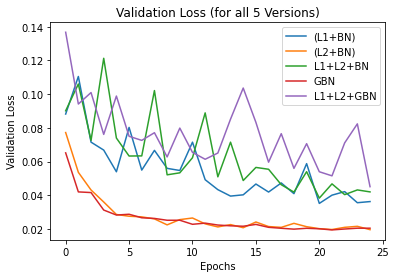

In [93]:
x = [i for i in range(0,epochs)]
y = test_loss_lists
legend_names = ['(L1+BN)','(L2+BN)',('L1+L2+BN'),('GBN'),('L1+L2+GBN')]

val_loss = plt.figure()
plt.title("Validation Loss (for all 5 Versions)")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")

for i in range(0,len(y)):
    plt.plot(x, y[i], label = legend_names[i])

plt.legend()
plt.show()
my_dpi = 109
val_loss.savefig('../mnist_data/images/val_loss_5_versions.png',figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)

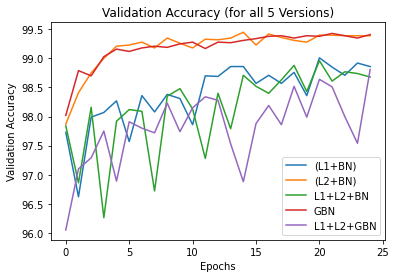

In [94]:
x = [i for i in range(0,epochs)]
y = test_acc_lists
legend_names = ['(L1+BN)','(L2+BN)',('L1+L2+BN'),('GBN'),('L1+L2+GBN')]

val_acc = plt.figure()
plt.title("Validation Accuracy (for all 5 Versions)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

for i in range(0,len(y)):
    plt.plot(x, y[i], label = legend_names[i])

plt.legend()
plt.show()
my_dpi = 109
val_acc.savefig('../mnist_data/images/val_acc_5_versions.png',figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)

## **[9] Results**

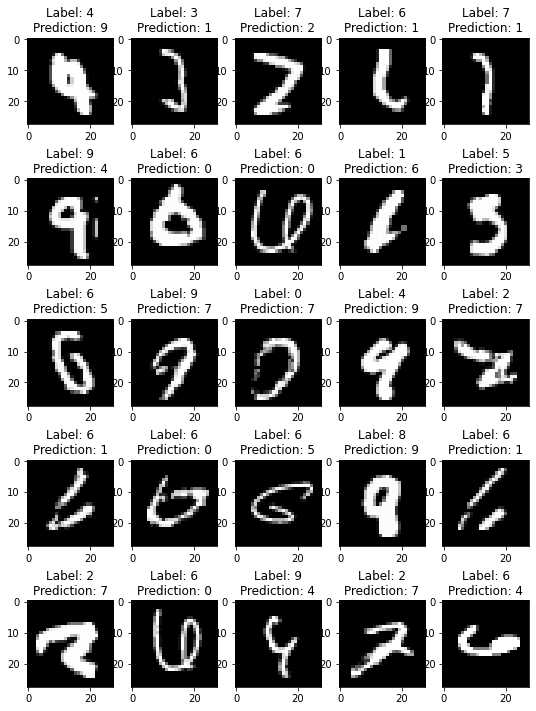

In [97]:
num_row     = 5
num_col     = 5
num_images  = num_row*num_col
batch_size_test = 1024

# Empty lists for storing the misclassified images, their corresponding predicitons and labels
mis_images = []
mis_labels = []
mis_pred   = []

GBN_MODEL_PATH = '../mnist_data/models/S6_best_model_version_4'
model = Net(BN_type='GBN')
model.load_state_dict(torch.load(GBN_MODEL_PATH))
model = model.to(device)
model.eval()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        images,labels  = data.to(device), target.to(device)
        output         = model(images)
        pred           = (output.argmax(dim=1, keepdim=True)).view_as(labels)
        mis_classified = pred.ne(labels).tolist()
        # 'mis_classified' is a Boolean list (size same as labels). 
        # It is True where the prediction does not match label
        if any(mis_classified) == True:
            mis_images.extend(images[mis_classified].cpu())
            mis_labels.extend(labels[mis_classified].cpu())
            mis_pred.extend(pred[mis_classified].cpu())
        
        if len(mis_pred)>=num_images:
            mis_images = mis_images[:25]
            mis_labels = mis_labels[:25]
            mis_pred = mis_pred[:25]
            break

# Plot the digit images with label and predictions
fig, axes = plt.subplots(num_row, num_col, figsize=(1.8*num_col,2.5*num_row))
for i in range(num_images):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(mis_images[i][0], cmap='gray')
    ax.set_title('Label: {}\nPrediction: {}'.format(mis_labels[i],mis_pred[i]))

plt.show()
fig.savefig('../mnist_data/images/S6_GBN_misclassified_images.png',figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)